In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from time import time

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("german_credit_data.xlsx")

In [3]:
data.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


### EDA

In [4]:
data.shape

(1000, 10)

In [5]:
data.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


#### Since Risk is the target variable, plotting the histogram to find out the distribution of values.

<Axes: xlabel='Risk', ylabel='Count'>

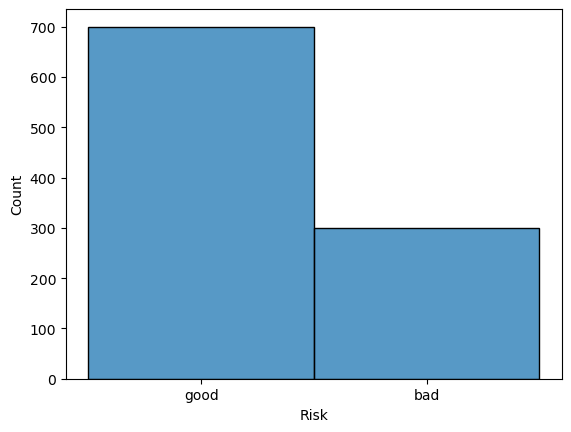

In [7]:
sb.histplot(data=data, x="Risk")

In [8]:
#Find the number of values per class in "Risk"
data['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

#### Observation:
<li> As you can see, the data is imbalanced as the target variable has more number of values as 'good' than of 'bad'. </li>

In [9]:
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

#### Observation
<li> There are missing values in 'Saving accounts' and 'Checking account'. </li>
<li> Since there are a lot of missing values in 'Checking account', we are going to remove that column as a part of data cleaning. </li>

In [10]:
data.drop('Checking account', axis=1, inplace=True)

In [11]:
data.head(10)

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,1169,6,radio/TV,good
1,22,female,2,own,little,5951,48,radio/TV,bad
2,49,male,1,own,little,2096,12,education,good
3,45,male,2,free,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,4870,24,car,bad
5,35,male,1,free,NaN,9055,36,education,good
6,53,male,2,own,quite rich,2835,24,furniture/equipment,good
7,35,male,3,rent,little,6948,36,car,good
8,61,male,1,own,rich,3059,12,radio/TV,good
9,28,male,3,own,little,5234,30,car,bad


### Remove all the missing values in 'Saving accounts' using SimpleImputer

In [12]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [13]:
missing_data = data.iloc[:, 4:5]

In [14]:
missing_data = imputer.fit_transform(missing_data)

In [15]:
missing_data_df = pd.DataFrame(missing_data, columns=['Saving accounts'])

In [16]:
missing_data_df

,Saving accounts
0,little
1,little
2,little
3,little
4,little
...,...
995,little
996,little
997,little
998,little


#### Remove the original column to add the column obtained using SimpleImputer

In [17]:
data = data.drop('Saving accounts', axis=1)

In [18]:
data_final = pd.concat([data, missing_data_df], axis=1)

In [19]:
data_final.head(10)

,Age,Sex,Job,Housing,Credit amount,Duration,Purpose,Risk,Saving accounts
0,67,male,2,own,1169,6,radio/TV,good,little
1,22,female,2,own,5951,48,radio/TV,bad,little
2,49,male,1,own,2096,12,education,good,little
3,45,male,2,free,7882,42,furniture/equipment,good,little
4,53,male,2,free,4870,24,car,bad,little
5,35,male,1,free,9055,36,education,good,little
6,53,male,2,own,2835,24,furniture/equipment,good,quite rich
7,35,male,3,rent,6948,36,car,good,little
8,61,male,1,own,3059,12,radio/TV,good,rich
9,28,male,3,own,5234,30,car,bad,little


In [20]:
data_final.isnull().sum()

Age                0
Sex                0
Job                0
Housing            0
Credit amount      0
Duration           0
Purpose            0
Risk               0
Saving accounts    0
dtype: int64

#### We can observe that there are no missing values in our data.

In [21]:
data_final.dtypes

Age                 int64
Sex                object
Job                 int64
Housing            object
Credit amount       int64
Duration            int64
Purpose            object
Risk               object
Saving accounts    object
dtype: object

In [22]:
X = data_final.drop('Risk', axis=1)
Y = data_final['Risk']

In [23]:
X.head(10)

,Age,Sex,Job,Housing,Credit amount,Duration,Purpose,Saving accounts
0,67,male,2,own,1169,6,radio/TV,little
1,22,female,2,own,5951,48,radio/TV,little
2,49,male,1,own,2096,12,education,little
3,45,male,2,free,7882,42,furniture/equipment,little
4,53,male,2,free,4870,24,car,little
5,35,male,1,free,9055,36,education,little
6,53,male,2,own,2835,24,furniture/equipment,quite rich
7,35,male,3,rent,6948,36,car,little
8,61,male,1,own,3059,12,radio/TV,rich
9,28,male,3,own,5234,30,car,little


In [24]:
Y.head(10)

0    good
1     bad
2    good
3    good
4     bad
5    good
6    good
7    good
8    good
9     bad
Name: Risk, dtype: object

### Age, Job, Credit Amount and Duration are numerical features whereas remaining are categorical features

### Perform One Hot Encoding for categorical features.

In [25]:
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

In [26]:
categorical_columns

['Sex', 'Housing', 'Purpose', 'Saving accounts']

In [27]:
en = OneHotEncoder(sparse_output=False)

In [28]:
oh_encoded = en.fit_transform(data_final[categorical_columns])

In [29]:
oh_encoded_df = pd.DataFrame(oh_encoded, columns=en.get_feature_names_out(categorical_columns))

In [30]:
df_encoded = pd.concat([X, oh_encoded_df], axis=1)

In [31]:
df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [32]:
df_encoded

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich
0,67,2,1169,6,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,22,2,5951,48,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,49,1,2096,12,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,45,2,7882,42,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,2,4870,24,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,1736,12,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
996,40,3,3857,30,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
997,38,2,804,12,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
998,23,2,1845,45,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
df_encoded.isnull().sum()

Age                            0
Job                            0
Credit amount                  0
Duration                       0
Sex_female                     0
Sex_male                       0
Housing_free                   0
Housing_own                    0
Housing_rent                   0
Purpose_business               0
Purpose_car                    0
Purpose_domestic appliances    0
Purpose_education              0
Purpose_furniture/equipment    0
Purpose_radio/TV               0
Purpose_repairs                0
Purpose_vacation/others        0
Saving accounts_little         0
Saving accounts_moderate       0
Saving accounts_quite rich     0
Saving accounts_rich           0
dtype: int64

In [34]:
df_numerical = pd.DataFrame(df_encoded, columns=['Age', 'Job', 'Credit amount', 'Duration'])

In [35]:
df_numerical.head(10)

,Age,Job,Credit amount,Duration
0,67,2,1169,6
1,22,2,5951,48
2,49,1,2096,12
3,45,2,7882,42
4,53,2,4870,24
5,35,1,9055,36
6,53,2,2835,24
7,35,3,6948,36
8,61,1,3059,12
9,28,3,5234,30


### Histograms of numerical features

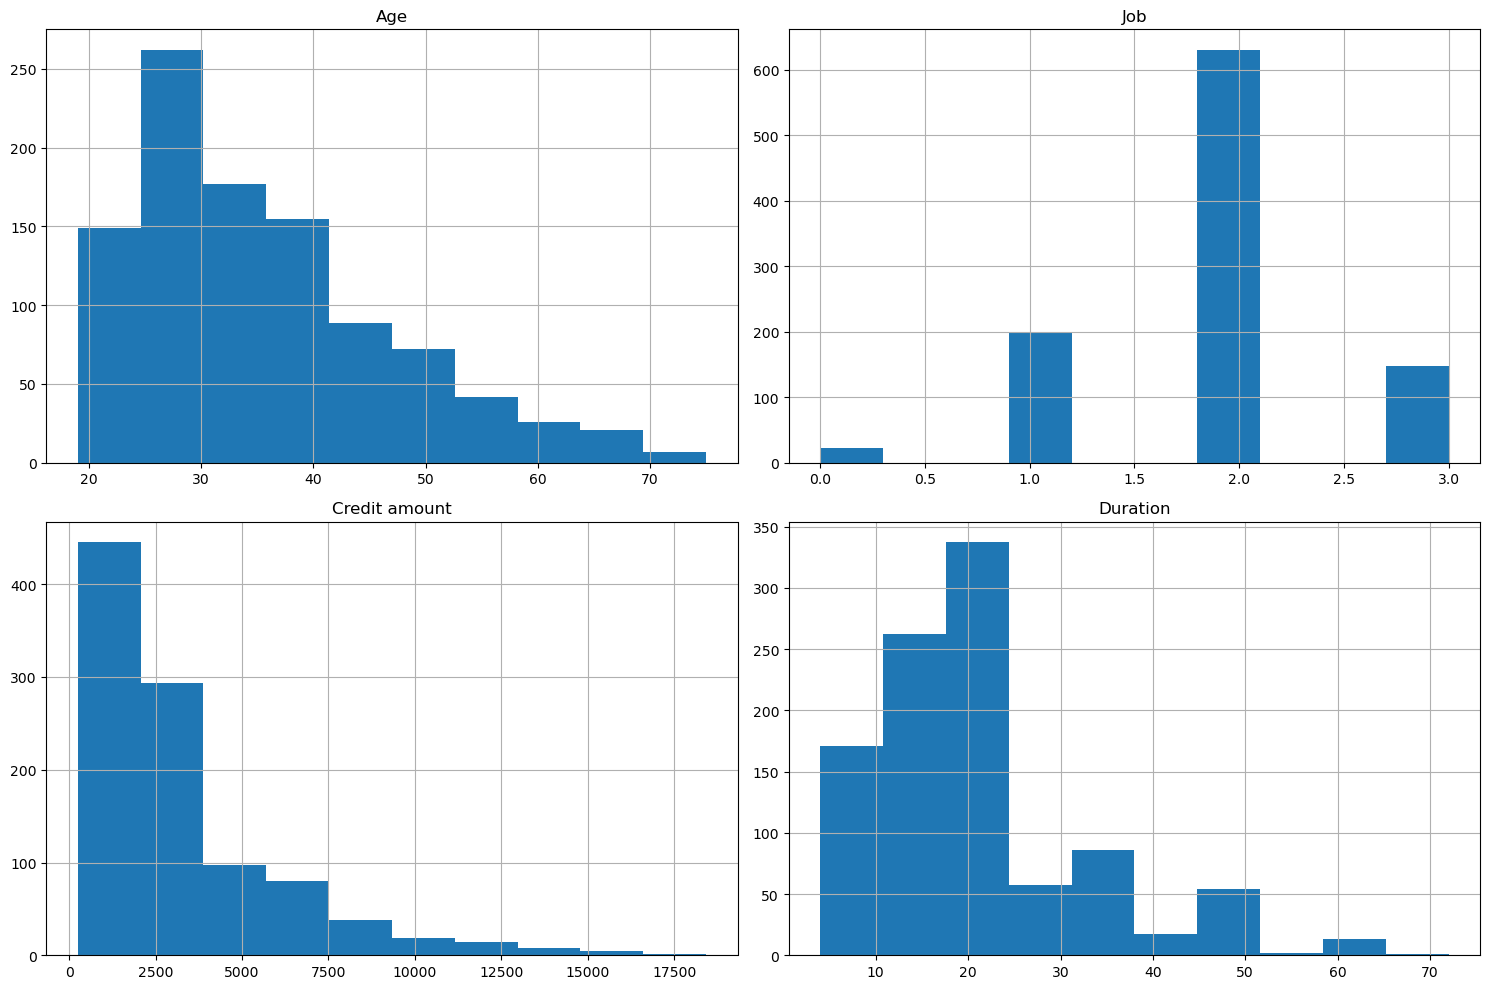

In [36]:
df_numerical.hist(figsize=(15,10))
plt.tight_layout()
plt.show()

#### Observation:
<li> Here we can observe that there is skewness in data for features - Age, Credit Amount and Duration. </li>
<li> Log transformations cannot be applied for the hot encoded features since all of them have 0 as one of the values and we cannot log transform it. So, log transformation is applied only to the required features instead of applying to the whole feature set.

### Apply Log Transformations to reduce skewness in numerical features

In [37]:
df_encoded['Age'] = np.log(df_encoded['Age'])

In [38]:
df_encoded['Credit amount'] = np.log(df_encoded['Credit amount'])

In [39]:
df_encoded['Duration'] = np.log(df_encoded['Duration'])

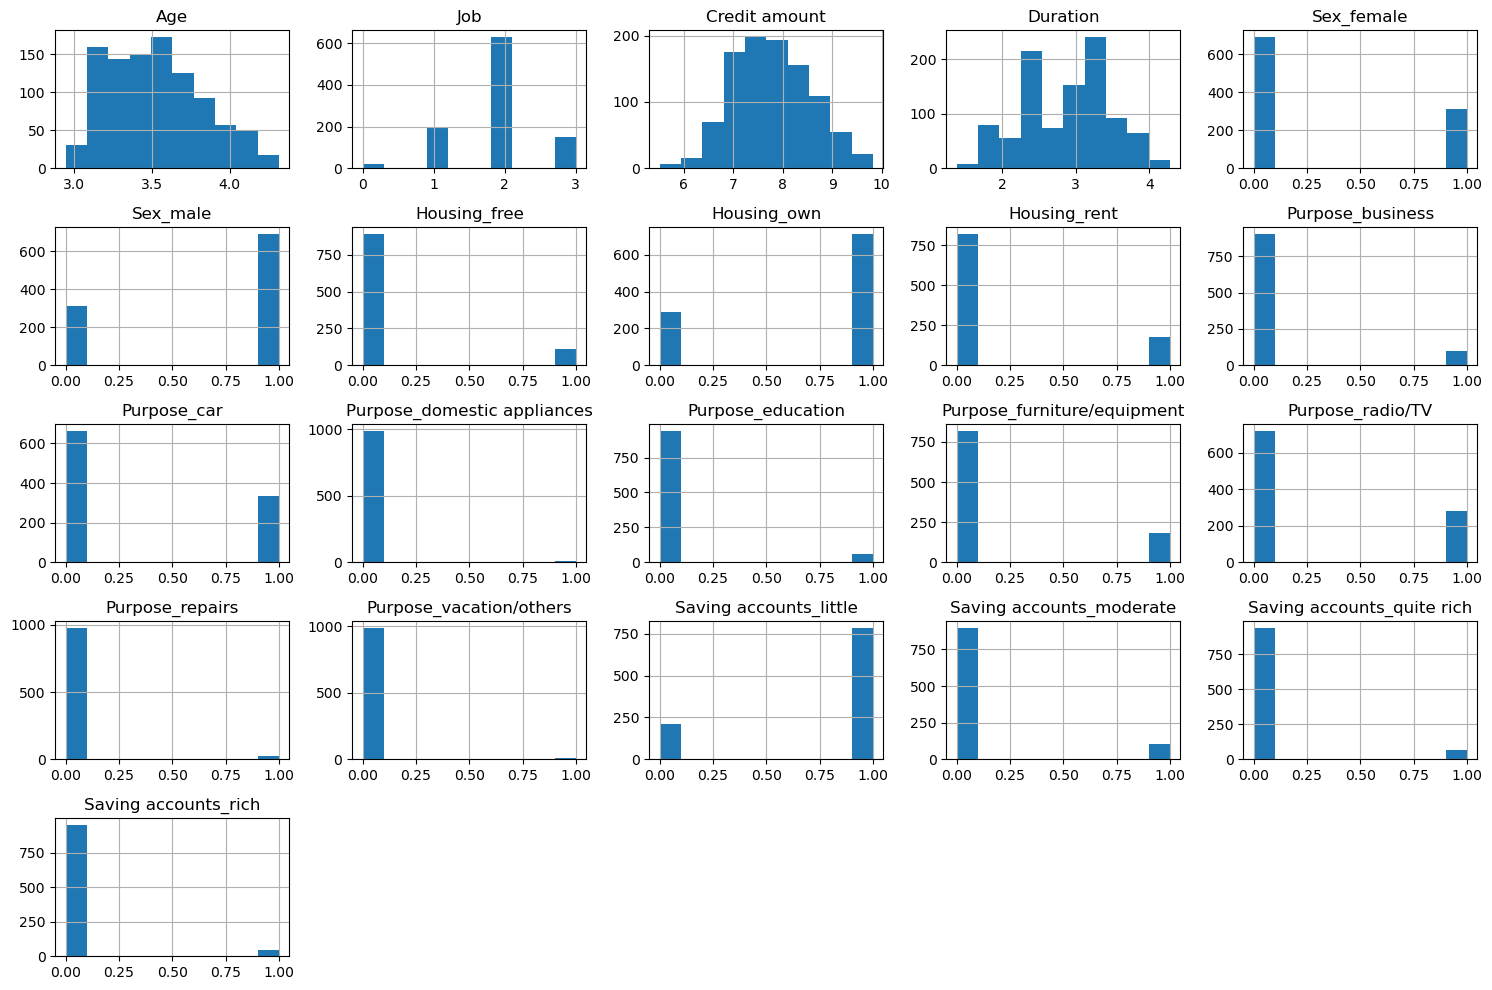

In [40]:
df_encoded.hist(figsize=(15,10))
plt.tight_layout()
plt.show()

#### Observation:
<li> Compared to the previous histograms, there's no skewness in Age, Credit Amount and Duration as tail of the graph is not pointing towards left or right. </li>

### Feature Scaling

In [41]:
df_scaled = StandardScaler().fit_transform(df_encoded)

In [42]:
df_scaled[:5]

array([[ 2.27100592,  0.14694918, -0.933901  , -1.86486906, -0.67028006,
         0.67028006, -0.3479601 ,  0.63444822, -0.4669334 , -0.32774947,
        -0.71294854, -0.11020775, -0.2503982 , -0.47010767,  1.60356745,
        -0.14998296, -0.11020775,  0.52178983, -0.33886163, -0.25929878,
        -0.22454436],
       [-1.44615223,  0.14694918,  1.16304581,  1.7083687 ,  1.49191369,
        -1.49191369, -0.3479601 ,  0.63444822, -0.4669334 , -0.32774947,
        -0.71294854, -0.11020775, -0.2503982 , -0.47010767,  1.60356745,
        -0.14998296, -0.11020775,  0.52178983, -0.33886163, -0.25929878,
        -0.22454436],
       [ 1.22669602, -1.38377145, -0.1815588 , -0.67378981, -0.67028006,
         0.67028006, -0.3479601 ,  0.63444822, -0.4669334 , -0.32774947,
        -0.71294854, -0.11020775,  3.99363901, -0.47010767, -0.62360956,
        -0.14998296, -0.11020775,  0.52178983, -0.33886163, -0.25929878,
        -0.22454436],
       [ 0.94245501,  0.14694918,  1.52514806,  1.47891314

#### A graph to find out if the variables are normally distributed after feature scaling.

<Axes: ylabel='Density'>

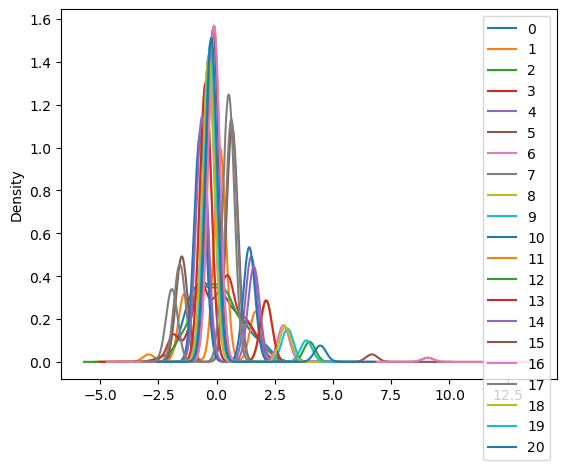

In [43]:
pd.DataFrame(df_scaled).plot(kind='kde')

In [44]:
data_final = pd.DataFrame(df_scaled, columns=df_encoded.columns)

In [45]:
data_final.head(10)

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich
0,2.271006,0.146949,-0.933901,-1.864869,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
1,-1.446152,0.146949,1.163046,1.708369,1.491914,-1.491914,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
2,1.226696,-1.383771,-0.181559,-0.673790,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,3.993639,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
3,0.942455,0.146949,1.525148,1.478913,-0.670280,0.670280,2.873893,-1.576173,-0.466933,-0.327749,...,-0.110208,-0.250398,2.127172,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
4,1.488620,0.146949,0.904743,0.517289,-0.670280,0.670280,2.873893,-1.576173,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
5,0.103614,-1.383771,1.703911,1.214026,-0.670280,0.670280,2.873893,-1.576173,-0.466933,-0.327749,...,-0.110208,3.993639,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
6,1.488620,0.146949,0.207588,0.517289,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,2.127172,-0.623610,-0.149983,-0.110208,-1.91648,-0.338862,3.856555,-0.224544
7,0.103614,1.677670,1.362630,1.214026,-0.670280,0.670280,-0.347960,-1.576173,2.141633,-0.327749,...,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
8,1.957856,-1.383771,0.305575,-0.673790,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,-1.91648,-0.338862,-0.259299,4.453463
9,-0.641198,1.677670,0.997621,0.900731,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544


In [46]:
data_final.dtypes

Age                            float64
Job                            float64
Credit amount                  float64
Duration                       float64
Sex_female                     float64
Sex_male                       float64
Housing_free                   float64
Housing_own                    float64
Housing_rent                   float64
Purpose_business               float64
Purpose_car                    float64
Purpose_domestic appliances    float64
Purpose_education              float64
Purpose_furniture/equipment    float64
Purpose_radio/TV               float64
Purpose_repairs                float64
Purpose_vacation/others        float64
Saving accounts_little         float64
Saving accounts_moderate       float64
Saving accounts_quite rich     float64
Saving accounts_rich           float64
dtype: object

In [47]:
data_final.isnull().sum()

Age                            0
Job                            0
Credit amount                  0
Duration                       0
Sex_female                     0
Sex_male                       0
Housing_free                   0
Housing_own                    0
Housing_rent                   0
Purpose_business               0
Purpose_car                    0
Purpose_domestic appliances    0
Purpose_education              0
Purpose_furniture/equipment    0
Purpose_radio/TV               0
Purpose_repairs                0
Purpose_vacation/others        0
Saving accounts_little         0
Saving accounts_moderate       0
Saving accounts_quite rich     0
Saving accounts_rich           0
dtype: int64

#### Observation:
<li> We can notice that all of the features in the data are now numerical. </li>

### K-Means Clustering using Elbow Method

In [48]:
data_numeric = pd.DataFrame(data_final, columns=['Age', 'Job', 'Credit amount', 'Duration'])

In [49]:
data_numeric

,Age,Job,Credit amount,Duration
0,2.271006,0.146949,-0.933901,-1.864869
1,-1.446152,0.146949,1.163046,1.708369
2,1.226696,-1.383771,-0.181559,-0.673790
3,0.942455,0.146949,1.525148,1.478913
4,1.488620,0.146949,0.904743,0.517289
...,...,...,...,...
995,-0.301466,-1.383771,-0.424376,-0.673790
996,0.549317,1.677670,0.604255,0.900731
997,0.378110,0.146949,-1.416199,-0.673790
998,-1.297780,0.146949,-0.345911,1.597468


In [50]:
wcss = []
for i in range(2, 16):
    clustering = KMeans(n_clusters=i, random_state=5)
    clustering.fit(data_numeric)
    wcss.append(clustering.inertia_)

In [51]:
wcss

[2805.159602249922,
 2336.553915984457,
 2015.2554513095804,
 1790.6454058818751,
 1632.1549764209335,
 1486.6155002077235,
 1367.3140346587293,
 1278.5577607553946,
 1203.8138928831831,
 1130.7912379993572,
 1078.923929024219,
 1021.9576803848007,
 995.0199484900256,
 937.5041780162371]

#### An elbow plot has been used to find out the optimal number of clusters. Over x-axis we have number of clusters and over y-axis we have wcss(within cluster sum of square)
#### The optimal number of clusters in k-means is the point where graph forms an elbow.

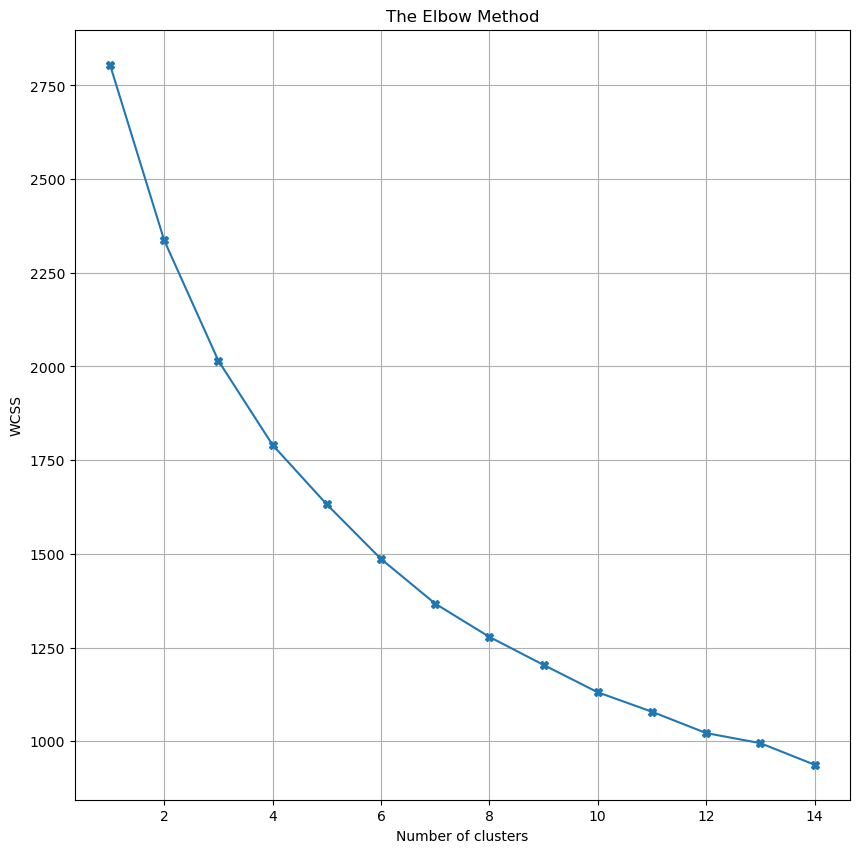

In [52]:
plt.figure(figsize=(10,10))
plt.plot(range(1,15), wcss, marker='X')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method')
plt.grid()
plt.show()

#### Observation:
In the above graph, the elbow point comes at around number of clusters(n)=6 which will be the optimal number of clusters for the above data. After n=6, as we keep on increasing the number of clusters, the wcss decreases slightly.
Hence, the optimal number of clusters=6

In [53]:
kmeans = KMeans(n_clusters=6)
y_kmeans = kmeans.fit(data_final)

In [54]:
print('Sum of the squared error: {}'.format(kmeans.inertia_))
print('Centroids: {}'.format(kmeans.cluster_centers_))

Sum of the squared error: 14279.365767435436
Centroids: [[-1.97473178e-01 -1.02023452e-01 -2.85563295e-01 -1.85819244e-01
   1.49191369e+00 -1.49191369e+00 -3.47960103e-01  6.34448220e-01
  -4.66933396e-01 -8.34944918e-02 -1.90427177e-01  5.57677790e-02
   5.63996751e-02  9.31578601e-02  1.67977447e-01 -2.67768040e-02
  -1.10207754e-01  3.60217709e-01 -3.38861626e-01 -2.59298784e-01
   8.54440875e-02]
 [ 1.25199134e-01 -5.93181384e-02  2.18542109e-04 -7.64958442e-03
  -6.70280063e-01  6.70280063e-01 -3.47960103e-01  6.34448220e-01
  -4.66933396e-01  6.36551751e-02 -1.77598212e-02 -2.33616121e-02
  -7.98340521e-02 -9.59704149e-03  5.03352536e-02  2.73018622e-02
  -1.10207754e-01  3.71919795e-01 -3.38861626e-01 -2.59298784e-01
   6.29927431e-02]
 [ 7.11385050e-01  4.25262022e-01  5.50224314e-01  4.49797635e-01
  -3.42674949e-01  3.42674949e-01  2.87389270e+00 -1.57617276e+00
  -4.66933396e-01 -1.91229851e-01  4.41001082e-01 -1.10207754e-01
   3.92637745e-01 -1.81521009e-01 -3.53648714e-0

### PCA

In [55]:
pca = PCA(n_components=6)
german_data_pca_6 = pca.fit_transform(data_final)

In [56]:
pca.explained_variance_ratio_

array([0.11833021, 0.10440294, 0.08923184, 0.07720514, 0.06569601,
       0.06264465])

#### Apply Label Encoder to convert the target variable from categorical to a binary feature so that it can be used for further classification

In [57]:
le = LabelEncoder()
data['Risk'] = le.fit_transform(data['Risk'])

In [58]:
data['Risk'].head(10)

0    1
1    0
2    1
3    1
4    0
5    1
6    1
7    1
8    1
9    0
Name: Risk, dtype: int32

#### Since all the 6 principal components cannot be visualized over a graph, the first 2 principal components have been chosen and visualized over a graph.
#### Since we have only 2 possible values for target variable ('good', 'bad'), we can see 2 different colours in the graph

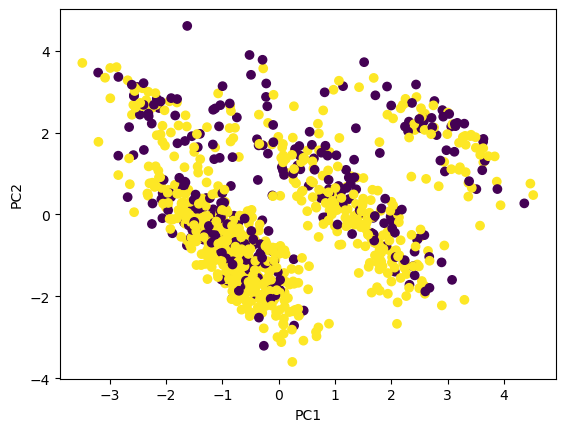

In [60]:
plt.scatter(german_data_pca_6[:,0], german_data_pca_6[:,1], c=data['Risk'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### Split the data into train and test sets

In [61]:
data_final.head(10)

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich
0,2.271006,0.146949,-0.933901,-1.864869,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
1,-1.446152,0.146949,1.163046,1.708369,1.491914,-1.491914,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
2,1.226696,-1.383771,-0.181559,-0.673790,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,3.993639,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
3,0.942455,0.146949,1.525148,1.478913,-0.670280,0.670280,2.873893,-1.576173,-0.466933,-0.327749,...,-0.110208,-0.250398,2.127172,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
4,1.488620,0.146949,0.904743,0.517289,-0.670280,0.670280,2.873893,-1.576173,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
5,0.103614,-1.383771,1.703911,1.214026,-0.670280,0.670280,2.873893,-1.576173,-0.466933,-0.327749,...,-0.110208,3.993639,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
6,1.488620,0.146949,0.207588,0.517289,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,2.127172,-0.623610,-0.149983,-0.110208,-1.91648,-0.338862,3.856555,-0.224544
7,0.103614,1.677670,1.362630,1.214026,-0.670280,0.670280,-0.347960,-1.576173,2.141633,-0.327749,...,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544
8,1.957856,-1.383771,0.305575,-0.673790,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,-1.91648,-0.338862,-0.259299,4.453463
9,-0.641198,1.677670,0.997621,0.900731,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-0.327749,...,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0.52179,-0.338862,-0.259299,-0.224544


In [62]:
data['Risk'].head(10)

0    1
1    0
2    1
3    1
4    0
5    1
6    1
7    1
8    1
9    0
Name: Risk, dtype: int32

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(data_final, data['Risk'], test_size=0.4)

### 5 Fold CV using Random Forest

In [65]:
rf_classifier = RandomForestClassifier()
scores = cross_val_score(rf_classifier, data_final, data['Risk'], cv=5)

In [66]:
scores

array([0.685, 0.695, 0.7  , 0.72 , 0.69 ])

### SVC

In [67]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [68]:
svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(svc, parameters, cv=5)
model = cv.fit(data_final, data['Risk'].values.ravel())

print_results(cv)

BEST PARAMS: {'C': 0.1, 'kernel': 'linear'}

0.7 (+/-0.0) for {'C': 0.1, 'kernel': 'linear'}
0.7 (+/-0.0) for {'C': 0.1, 'kernel': 'rbf'}
0.7 (+/-0.0) for {'C': 1, 'kernel': 'linear'}
0.694 (+/-0.028) for {'C': 1, 'kernel': 'rbf'}
0.7 (+/-0.0) for {'C': 10, 'kernel': 'linear'}
0.663 (+/-0.044) for {'C': 10, 'kernel': 'rbf'}


In [69]:
cv.best_estimator_

SVC(C=0.1, kernel='linear')

In [70]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))


In [71]:
evaluate_model('SVC', cv.best_estimator_, X_test, Y_test)

SVC -- Accuracy: 0.758 / Precision: 0.758 / Recall: 1.0 / Latency: 7.9ms


#### Observation:
<li> After using all the possible combinations of Support Vector Machine parameter using hyperparameter tuning, the best performance of the model is obtained at C=0.1 and kernel='linear'</li>
<li> The accuracy of the model is 0.758, precision is 0.758 and recall of 1 with a total latency of 7.9ms </li>